# Linear Risk model for Retinopathy in diabetes

### Diabetic Retinopathy
Retinopathy is an eye condition that causes changes to the blood vessels in the part of the eye called the retina.
This often leads to vision changes or blindness.
Diabetic patients are known to be at high risk for retinopathy. 

### Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Load Data

In [2]:
X = pd.read_csv('X_data.csv',index_col=0)
y_df = pd.read_csv('y_data.csv',index_col=0)
y = y_df['y']

`X` and `y` are Pandas DataFrames that hold the data for 6,000 diabetic patients. 

### Explore the Dataset

The features (`X`) include the following fields:
* Age: (years)
* Systolic_BP: Systolic blood pressure (mmHg)
* Diastolic_BP: Diastolic blood pressure (mmHg)
* Cholesterol: (mg/DL)
    
We can use the `head()` method to display the first few records of each.    

In [3]:
X.head()

,Age,Systolic_BP,Diastolic_BP,Cholesterol
0,77.196340,85.288742,80.021878,79.957109
1,63.529850,99.379736,84.852361,110.382411
2,69.003986,111.349455,109.850616,100.828246
3,82.638210,95.056128,79.666851,87.066303
4,78.346286,109.154591,90.713220,92.511770


The target (`y`) is an indicator of whether or not the patient developed retinopathy.

* y = 1 : patient has retinopathy.
* y = 0 : patient does not have retinopathy.

In [4]:
y.head()

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: y, dtype: float64

The data has been splitted into train and test sets using a 75/25 split.
For this, we can use the built in function provided by sklearn library.

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=0)

Histograms of each column of `X_train`

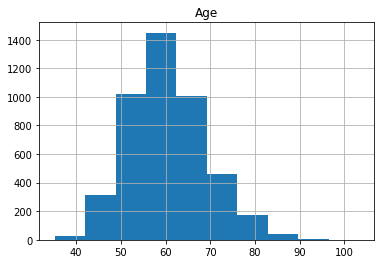

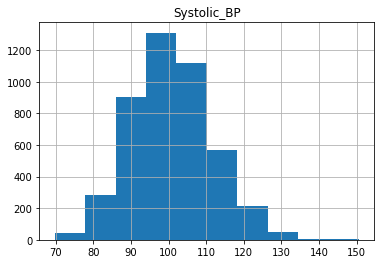

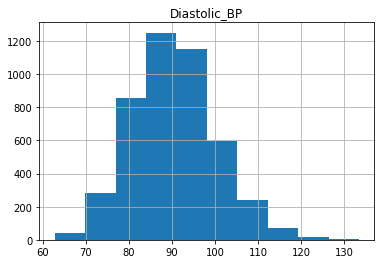

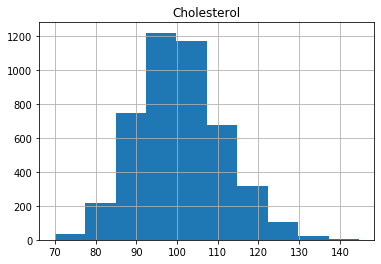

In [7]:
for col in X.columns:
    X_train_raw.loc[:, col].hist()
    plt.title(col)
    plt.show()

As we can see, the distributions have a generally bell shaped distribution, but with slight rightward skew.
We can transform our data to be closer to a normal distribution by removing the skew. We can do this by applying the log function to the data. 
Let's plot the log of the feature variables to see that it produces the desired effect.

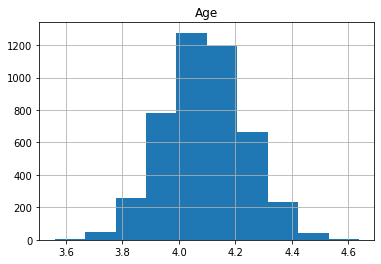

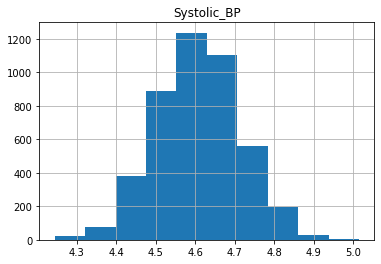

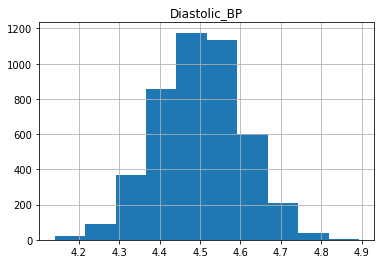

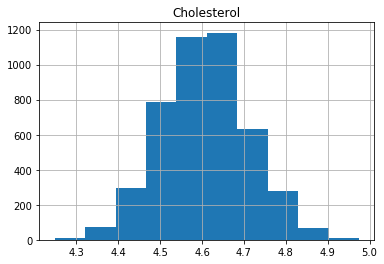

In [8]:
for col in X_train_raw.columns:
    np.log(X_train_raw.loc[:, col]).hist()
    plt.title(col)
    plt.show()

We can see that the data is more symmetric after taking the log.

### Mean-Normalize the Data

Let's now transform our data so that the distributions are closer to standard normal distributions.

First we will remove some of the skew from the distribution by using the log transformation.
Then we will "standardize" the distribution so that it has a mean of zero and standard deviation of 1. It is so because a standard normal distribution has mean of zero and standard deviation of 1. 


In [9]:
def make_standard_normal(df_train, df_test):
    
    # Removing skew by applying the log function to the train set, and to the test set
    df_train_unskewed = np.log(df_train)
    df_test_unskewed = np.log(df_test)
    
    # Calculating the mean and standard deviation of the training set
    mean = df_train_unskewed.mean(axis = 0)
    stdev = df_train_unskewed.std(axis = 0)
    
    # Standardizing the training set
    df_train_standardized = (df_train_unskewed-mean)/stdev
    
    # Standardizing the test set
    df_test_standardized = (df_test_unskewed-mean)/stdev
    
    return df_train_standardized, df_test_standardized

#### Transform training and test data 
Using the function implemented above.

In [10]:
X_train, X_test = make_standard_normal(X_train_raw, X_test_raw)

### Building the Model

In [11]:
def lr_model(X_train, y_train):
    
    # Importing the LogisticRegression class
    from sklearn.linear_model import LogisticRegression
    
    # Creating the model object
    model = LogisticRegression()
    
    # Fitting the model to the training data
    model.fit(X_train,y_train)
    
    return model

In [12]:
model_X = lr_model(X_train, y_train)

### Evaluate the Model Using the C-index

* The c-index measures the discriminatory power of a risk score. 
* Intuitively, a higher c-index indicates that the model's prediction is in agreement with the actual outcomes of a pair of patients.
* The formula for the c-index is

$$ \mbox{cindex} = \frac{\mbox{concordant} + 0.5 \times \mbox{ties}}{\mbox{permissible}} $$

* A permissible pair is a pair of patients who have different outcomes.
* A concordant pair is a permissible pair in which the patient with the higher risk score also has the worse outcome.
* A tie is a permissible pair where the patients have the same risk score.


#### Insights
* `y_true` is the array of actual patient outcomes, 0 if the patient does not eventually get the disease, and 1 if the patient eventually gets the disease.
* `scores` is the risk score of each patient.  These provide relative measures of risk, so they can be any real numbers. By convention, they are always non-negative.
* Here is an example of input data and how to interpret it:
```Python
y_true = [0,1]
scores = [0.45, 1.25]
```
    * There are two patients. Index 0 of each array is associated with patient 0.  Index 1 is associated with patient 1.
    * Patient 0 does not have the disease in the future (`y_true` is 0), and based on past information, has a risk score of 0.45.
    * Patient 1 has the disease at some point in the future (`y_true` is 1), and based on past information, has a risk score of 1.25.

In [13]:
def cindex(y_true, scores):
    n = len(y_true)
    assert len(scores) == n

    concordant = 0
    permissible = 0
    ties = 0
    
    # Two nested for loops to go through all unique pairs of patients
    for i in range(n):
        for j in range(i+1, n):
            
            # Checking if the pair is permissible (the patient outcomes are different)
            if y_true[i] != y_true[j]:
                # Counting the pair if it's permissible
                permissible += 1

                # For permissible pairs, checking if they are concordant or are ties

                # Checking for ties in the score
                if scores[i] == scores[j]:
                    # Counting the tie
                    ties += 1
                    # If it's a tie, we don't need to check patient outcomes, continue to the top of the for loop.
                    continue

                # Case 1: Patient i doesn't get the disease, patient j does
                if y_true[i] == 0 and y_true[j] == 1:
                    # Checking if patient i has a lower risk score than patient j
                    if scores[i] < scores[j]:
                        # Counting the concordant pair
                        concordant += 1
                    # Otherwise if patient i has a higher risk score, it's not a concordant pair.
                    # Already checked for ties earlier

                # Case 2: Patient i gets the disease, patient j does not
                if y_true[i] == 1 and y_true[j] == 0:
                    # Checking if patient i has a higher risk score than patient j
                    if scores[i] > scores[j]:
                        #Counting the concordant pair
                        concordant += 1
                    # Otherwise if patient i has a lower risk score, it's not a concordant pair.
                    # Already checked for ties earlier

    # Calculating the c-index using the count of permissible pairs, concordant pairs, and tied pairs.
    c_index = (concordant + (0.5 * ties)) / permissible
    
    return c_index

### Evaluate the Model on the Test Set

Now, you can evaluate our trained model on the test set.  

To get the predicted probabilities, we use the `predict_proba` method. This method will return the result from the model *before* it is converted to a binary 0 or 1. For each input case, it returns an array of two values which represent the probabilities for both the negative case (patient does not get the disease) and positive case (patient the gets the disease). 

In [14]:
scores = model_X.predict_proba(X_test)[:, 1]
c_index_X_test = cindex(y_test.values, scores)
print(f"c-index on test set is {c_index_X_test:.4f}")

c-index on test set is 0.8182


Let's plot the coefficients to see which variables (patient features) are having the most effect.

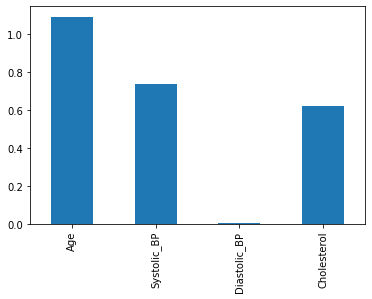

In [15]:
coeffs = pd.DataFrame(data = model_X.coef_, columns = X_train.columns)
coeffs.T.plot.bar(legend=None);

###  Improve the Model

Interaction terms improve the models performance.
* An interaction term is the product of two variables. 
    * For example, if we have data 
    $$ x = [x_1, x_2]$$
    * We could add the product so that:
    $$ \hat{x} = [x_1, x_2, x_1*x_2]$$
    

In [17]:
def add_interactions(X):
    
    features = X.columns
    m = len(features)
    X_int = X.copy(deep=True)

    # 'i' loops through all features in the original dataframe X
    for i in range(m):
        
        # Name of feature 'i'
        feature_i_name = features[i]
        
        # Data for feature 'i'
        feature_i_data = X_int.iloc[:,i]
        
        for j in range(i+1, m):
            
            # Name of feature 'j'
            feature_j_name = features[j]
            
            # Data for feature j'
            feature_j_data = X_int.iloc[:,j]
            
            # Name of the interaction feature by combining both names
            feature_i_j_name = f"{feature_i_name}_x_{feature_j_name}"
            
            # Multiplying the data for feature 'i' and feature 'j'
            X_int[feature_i_j_name] = feature_i_data * feature_j_data

    return X_int

Using interaction to transform `X_train` and `X_test`.

In [18]:
X_train_int = add_interactions(X_train)
X_test_int = add_interactions(X_test)

### Evaluate the Improved Model

In [19]:
model_X_int = lr_model(X_train_int, y_train)

Let's evaluate our new model on the test set.

In [20]:
scores_X = model_X.predict_proba(X_test)[:, 1]
c_index_X_int_test = cindex(y_test.values, scores_X)

scores_X_int = model_X_int.predict_proba(X_test_int)[:, 1]
c_index_X_int_test = cindex(y_test.values, scores_X_int)

print(f"c-index on test set without interactions is {c_index_X_test:.4f}")
print(f"c-index on test set with interactions is {c_index_X_int_test:.4f}")

c-index on test set without interactions is 0.8182
c-index on test set with interactions is 0.8281


We can see that the model with interaction terms performs a bit better than the model without interactions. But, before jumping to any further conclusions, let's first take another look at the model coefficients to try and see which variables made a difference.

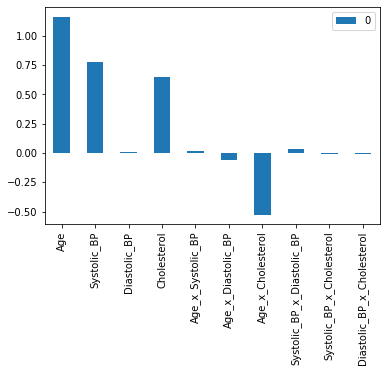

In [21]:
int_coeffs = pd.DataFrame(data = model_X_int.coef_, columns = X_train_int.columns)
int_coeffs.T.plot.bar();

### Inferences:
We may notice that Age, Systolic_BP, and Cholesterol have a positive coefficient. This means that a higher value in these three features leads to a higher prediction probability for the disease. We may also notice that the interaction of Age x Cholesterol has a negative coefficient. This means that a higher value for the Age x Cholesterol product reduces the prediction probability for the disease.

To understand the effect of interaction terms, let's compare the output of the model we've trained on sample cases with and without the interaction.

In [22]:
index = index = 3432
case = X_train_int.iloc[index, :]
print(case)

Age                           2.502061
Systolic_BP                   1.713547
Diastolic_BP                  0.268265
Cholesterol                   2.146349
Age_x_Systolic_BP             4.287400
Age_x_Diastolic_BP            0.671216
Age_x_Cholesterol             5.370296
Systolic_BP_x_Diastolic_BP    0.459685
Systolic_BP_x_Cholesterol     3.677871
Diastolic_BP_x_Cholesterol    0.575791
Name: 5970, dtype: float64


We can see that they have above average Age and Cholesterol. We can now see what our original model would have output by zero-ing out the value for Cholesterol and Age.

In [23]:
new_case = case.copy(deep=True)
new_case.loc["Age_x_Cholesterol"] = 0
new_case

Age                           2.502061
Systolic_BP                   1.713547
Diastolic_BP                  0.268265
Cholesterol                   2.146349
Age_x_Systolic_BP             4.287400
Age_x_Diastolic_BP            0.671216
Age_x_Cholesterol             0.000000
Systolic_BP_x_Diastolic_BP    0.459685
Systolic_BP_x_Cholesterol     3.677871
Diastolic_BP_x_Cholesterol    0.575791
Name: 5970, dtype: float64

In [24]:
print(f"Output with interaction: \t{model_X_int.predict_proba([case.values])[:, 1][0]:.4f}")
print(f"Output without interaction: \t{model_X_int.predict_proba([new_case.values])[:, 1][0]:.4f}")

Output with interaction: 	0.9448
Output without interaction: 	0.9965


We see that the model is less confident in its prediction with the interaction term than without (the prediction value is lower when including the interaction term). With the interaction term, the model has adjusted for the fact that the effect of high cholesterol becomes less important for older patients compared to younger patients. Thus, we must cautious when adding any interaction.